# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [1]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/cmdb/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/cmdb/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/anaconda3/envs/hpa-app/lib/python3.10/site-packages/bio

### 1b. Create Prediction Pipelines

In [2]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [3]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [4]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [5]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [11]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [69]:
#hpa = hpa_cyto
#hpa = hpa_endo
#hpa = hpa_mito
hpa = hpa_nucl

### 2b. Load Images

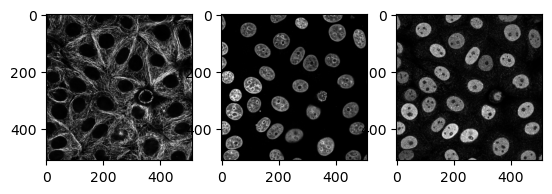

In [70]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [71]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


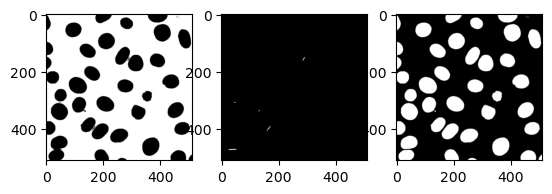

In [72]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [73]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [74]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

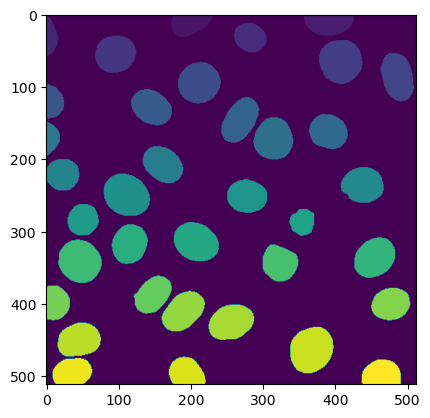

In [75]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [76]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


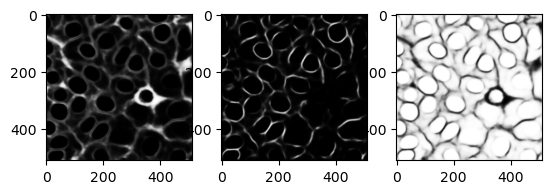

In [77]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

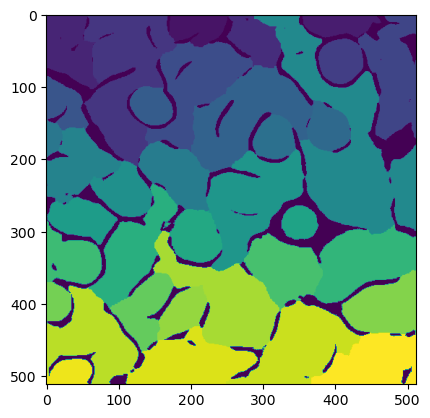

In [78]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [79]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [80]:
sizes

array([27269,  2846,  2724,  5341,  3694, 15393,  3051,  8741, 10135,
        2798,  2461, 12706,  3082,  2781,   871,  5929,  6160, 24570,
        4116, 12238,  3899,  1876,  4105,  8281,  9793,  4449,  6958,
        4771,  1603,  6366,  3188, 12028,  9272, 10779,  8684,  1846,
        7340])

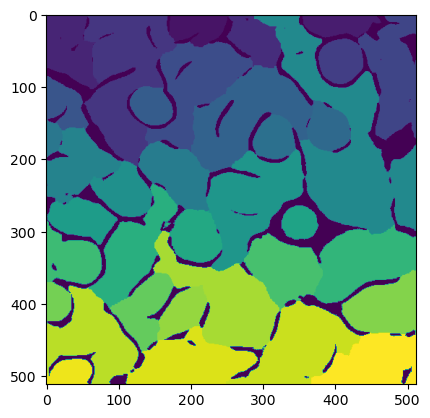

In [81]:
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

In [ ]:
#The watershed algorithm is used to separate objects in an image.
#It treats pixel values as local elevation.
#So brighter points would be "higher"
#You can choose markers that are the local maxima
#In this case it looks like we are using nuclei...
# because they are what we want to separate from the background 

In [ ]:
# Let's look at the plot with no mask

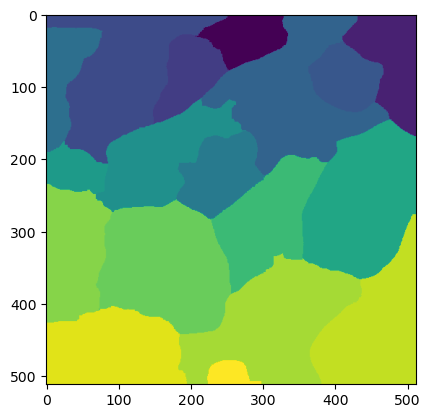

In [29]:
cell_seg_no_mask = watershed(bd, markers=nuclei)

plt.subplots()
plt.imshow(cell_seg_no_mask)

In [ ]:
#Without the mask, the boundaries between cells are not marked by lines
#They are just colored differently 

In [ ]:
#Let's look at the plot with no markers

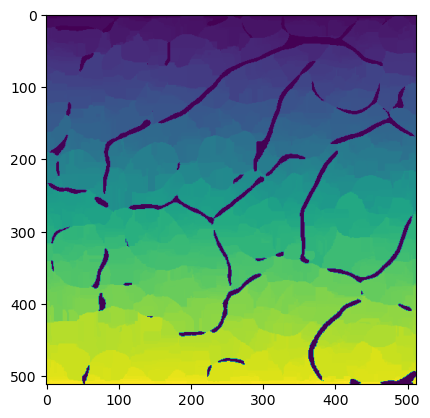

In [28]:
cell_seg_no_markers = watershed(bd, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg_no_markers)

In [ ]:
# Without markers, the boundaries are messily defined 

In [ ]:
# Repeat for cyto, endo, mito, and nucl

In [ ]:
# To do this, I redefined hpa with the different data sets 
# It does a particularly good job with the mito images
# I don't think it did a good job with the rest of them
# Fewer, well-defined, high-contrast and very separated objects are probably easiest to separate
# Cells that are crowded or have less regular morphology do not separate well